In [13]:
!pip install rdp
import sys
sys.path.append("../")
import numpy as np
import os
import glob
import cv2
import csv
from utils import findCentroid, find_boundaries
import pandas as pd
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
from pathlib import Path
import napari
from numpy import diff, polyfit
from scipy import interpolate
import math
from rdp import rdp
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
refvec = [0, 1]
def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0], point[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

  Created wheel for rdp: filename=rdp-0.8-cp37-none-any.whl size=4569 sha256=7f998a445ab44fd5c07b3b4cc5c7f5b4eb3b8da30fb6dcfa91a3eb92b7eccf5c
  Stored in directory: /home/sancere/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [28]:
WingDir = '/home/sancere/Desktop/Test/'

Raw_path = os.path.join(WingDir, '*tif')
Dir = glob.glob(Raw_path)


/home/sancere/Desktop/Test/bucket.tif
/home/sancere/Desktop/Test/bucket2.tif
/home/sancere/Desktop/Test/bucket3.tif


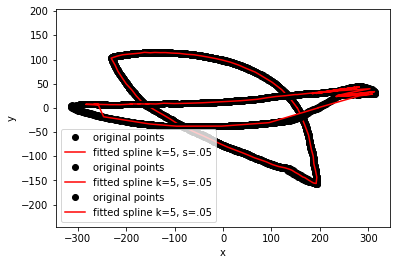

In [29]:
count = 0 
splines = []

for fname in Dir:
        print(fname)
        count = count + 1
        SurfaceImage = find_boundaries(imread(fname).astype('float32'))

        centroid, coords = findCentroid(SurfaceImage.astype('uint16'))
        coords = coords - centroid
        coords = sorted(coords, key=clockwiseangle_and_distance)
        
        X = []
        Y = []
        for i in range(0, len(coords)):
           Y.append(coords[i][0])
           X.append(coords[i][1])
        points = rdp(np.array([X, Y]).T, epsilon = 0)
        # Linear length along the line:
        distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
        distance = np.insert(distance, 0, 0)/distance[-1]

        # Build a list of the spline function, one for each dimension:
        splines = [UnivariateSpline(distance, coords, k=3, s=.2) for coords in points.T]


        # Computed the spline for the asked distances:
        alpha = np.linspace(0, 1, 75)
        points_fitted = np.vstack( spl(alpha) for spl in splines ).T

        # Graph:
        plt.plot(*points.T, 'ok', label='original points');
        plt.plot(*points_fitted.T, '-r', label='fitted spline k=5, s=.05');
        plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

        plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
plt.savefig(WingDir + 'Trial' + '.png', dpi=300)    